In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

len(recordings)

100%|██████████| 10557/10557 [00:26<00:00, 400.05it/s]


10556

In [2]:

max_length = max(len(array) for array in recordings)  # Find the maximum length

# Pad each array to have the maximum length
padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])

In [3]:
valence_values = np.array(valence_values)
valence_values

array([1.25, 3.5 , 3.25, ..., 3.25, 3.75, 4.5 ])

In [14]:
unique_valence_list = sorted(list(set(valence_values)))

for i in tqdm(range(len(valence_values))):
    valence_values[i] = unique_valence_list.index(valence_values[i])
valence_values

100%|██████████| 10556/10556 [00:00<00:00, 1681800.24it/s]

array([ 1., 10.,  9., ...,  9., 11., 14.])

In [15]:
from sklearn.model_selection import train_test_split

# Split the data and labels into training and testing sets
X_train, X_test_help, y_train, y_test_help = train_test_split(padded_arrays, valence_values, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test_help, y_test_help, test_size=0.5, random_state=42)


array([ 7.,  9., 12., ..., 15., 14., 15.])

# Length of recordings distribution

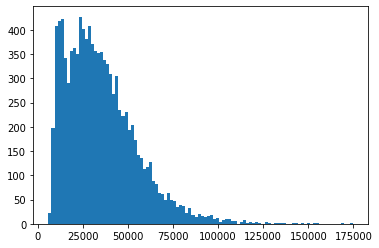

10556
5605


In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(length_list, bins=100)
plt.show()

print(len(length_list))
print(len(np.unique(np.array(length_list))))



# Valence distribution

In [24]:
valence_dict = {}

for i in valence_values:
    if i not in valence_dict:
        valence_dict[i] = 1
    else:
        valence_dict[i] += 1
valence_dict


{1.0: 140,
 10.0: 1194,
 9.0: 1299,
 11.0: 989,
 4.0: 528,
 7.0: 1031,
 5.0: 694,
 8.0: 1063,
 13.0: 613,
 0.0: 114,
 2.0: 229,
 3.0: 408,
 15.0: 151,
 12.0: 801,
 6.0: 907,
 16.0: 28,
 14.0: 367}

In [25]:
import torch

# Convert input data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Use float32 for input features

# Convert labels
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use long if your labels are for classification tasks

from torch.utils.data import TensorDataset, DataLoader

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
batch_size = 64  # You can adjust the batch size depending on your system's capability
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [26]:
y_test_tensor

tensor([ 8,  8,  9,  ..., 12,  9, 10])

# Plan


### 1. Neural network with padding

### 2. Neural network with 1 input 1 hidden 1 output layer

### 3. Optimizer : ADAM 

### 4. Loss function - Categorical cross entropy



In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_function):
        """
        Initialize the MLP model.

        Parameters:
        - input_size (int): Size of the input features.
        - hidden_sizes (list): List containing the sizes of hidden layers.
        - output_size (int): Size of the output layer.
        - activation_function (torch.nn.Module): Activation function for hidden layers.
        """
        super(MLP, self).__init__()

        # Set random seed for reproducibility
        torch.manual_seed(42)

        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Create hidden layers and activations dynamically
        self.layers = nn.ModuleList()

        for i in range(len(hidden_sizes)):
            # Linear layer
            self.layers.append(nn.Linear(input_size if i == 0 else hidden_sizes[i - 1], hidden_sizes[i]))

            # Activation function (except for the last layer)
            self.layers.append(activation_function())

        # Append the ouptu layer
        self.layers.append(nn.Softmax(dim=1))
        

    def forward(self, x):
 
        # Flatten the input
        x = x.view(-1, self.input_size)

        # Forward pass through hidden layers with activation functions
        for layer in self.layers:
            x = layer(x)

        return x


In [44]:
# Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0

        for inputs, labels in test_loader:
            inputs = inputs.view(-1, max_length)  # Flatten the images
            outputs = MLP_model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass

            # Update weights using the step function of our custom ADAM optimizer
            optimizer.step()

            # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
            total_loss += loss.item()
    
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
    

In [45]:
def evaluate_model(MLP_model, test_loader):
    # Model Evaluation
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        MLP_model.eval()  # Set the model to evaluation mode
        total_correct = 0
        total_samples = 0

        for inputs, labels in test_loader:
            inputs = inputs.view(-1, max_length)  # Flatten the test images
            outputs = MLP_model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.numpy())
            true_labels.extend(labels.numpy())
            
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(predicted_labels)
    print("True Labels:")
    print(true_labels)


In [46]:

# Initialize the model
input_size = max_length  # MNIST images are 28x28 pixels
hidden_size = [32, 32]
output_size = 17  # 10 classes for digits 0 to 9
activation_function = nn.ReLU
num_epochs = 20

# Create the model
model = MLP(input_size, hidden_size, output_size, activation_function)

# Here we create an instance of our custom_SGD class, giving as arguments the learning rate.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, optimizer, num_epochs=num_epochs)

# Evaluate the model
evaluate_model(model, test_loader)


Epoch [1/20], Loss: 1.1547
Epoch [2/20], Loss: 1.1126
Epoch [3/20], Loss: 1.0642
Epoch [4/20], Loss: 1.0203
Epoch [5/20], Loss: 0.9868
Epoch [6/20], Loss: 0.9644
Epoch [7/20], Loss: 0.9533
Epoch [8/20], Loss: 0.9466
Epoch [9/20], Loss: 0.9430
Epoch [10/20], Loss: 0.9404
Epoch [11/20], Loss: 0.9394
Epoch [12/20], Loss: 0.9387
Epoch [13/20], Loss: 0.9382
Epoch [14/20], Loss: 0.9383
Epoch [15/20], Loss: 0.9377
Epoch [16/20], Loss: 0.9375
Epoch [17/20], Loss: 0.9373
Epoch [18/20], Loss: 0.9372
Epoch [19/20], Loss: 0.9369
Epoch [20/20], Loss: 0.9373
Test Accuracy: 70.55%
[5, 11, 9, 9, 11, 11, 12, 9, 10, 7, 12, 10, 7, 9, 10, 11, 7, 13, 10, 1, 10, 13, 12, 10, 7, 13, 10, 9, 13, 12, 11, 13, 3, 10, 5, 7, 7, 15, 5, 11, 13, 11, 10, 12, 11, 9, 12, 4, 5, 5, 7, 9, 15, 10, 10, 12, 5, 1, 4, 0, 4, 9, 10, 9, 10, 5, 13, 4, 7, 11, 7, 12, 12, 12, 11, 0, 13, 10, 3, 11, 9, 3, 9, 5, 5, 4, 9, 15, 11, 9, 0, 7, 12, 4, 11, 11, 12, 11, 14, 15, 13, 1, 12, 11, 9, 14, 12, 5, 12, 3, 10, 10, 4, 14, 11, 11, 4, 9, 7, 9, 7